In [ ]:
from fastai.text import *
from fastai import *

In [ ]:
df = pd.read_csv("data/bank_data.csv")
df.head()

,tweet,sentiment,date,weekday,hour,followers,description
0,because they answered you doesnt mean they are...,0,2019-03-06 05:15:05,2.0,5.0,521.0,arab academy alumni member of the nautical in...
1,because they answered you doesnt mean they are...,0,2019-03-06 05:15:05,2.0,5.0,521.0,arab academy alumni member of the nautical in...
2,there you have it,0,2019-03-06 05:03:39,2.0,5.0,708.0,without christs mercy my life is messychartere...
3,ok i understand and i also have some questions...,0,2019-03-06 05:01:35,2.0,5.0,1949.0,am a blogger pr and also a music producer
4,i have not been able to use my first bank appl...,1,2019-03-06 04:34:43,2.0,4.0,14.0,principal consultant green consulting


In [ ]:
import math

In [ ]:
df_1 = df.loc[:,["tweet","sentiment"]]

In [ ]:
index = df_1.isna()[df_1[["tweet"]].isna()["tweet"] == True].index

In [ ]:
df_1.drop(index,inplace=True)

In [ ]:
df_1.isna().sum()

tweet        0
sentiment    0
dtype: int64

In [ ]:
mm = {
    1:"neg",
    0:"pos"
}
# valid_df["label"] = valid_df["sentiment"].map(mm)
# train_df["label"] = train_df["sentiment"].map(mm)

df_1["label"] = df_1["sentiment"].map(mm)

In [ ]:
df_1[["label"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7490 entries, 0 to 7533
Data columns (total 1 columns):
label    7490 non-null object
dtypes: object(1)
memory usage: 117.0+ KB


In [ ]:
split = math.floor((len(df_1) - len(df_1)*0.1))
train_df = df_1[:split].reset_index()
valid_df = df_1[split:].reset_index()

In [ ]:
valid_df.drop("index",axis=1,inplace=True)
train_df.drop("index",axis=1,inplace=True)

In [ ]:
df_1.head()

,tweet,sentiment,label
0,because they answered you doesnt mean they are...,0,pos
1,because they answered you doesnt mean they are...,0,pos
2,there you have it,0,pos
3,ok i understand and i also have some questions...,0,pos
4,i have not been able to use my first bank appl...,1,neg


In [ ]:
valid_df.drop("sentiment",axis=1,inplace=True)
train_df.drop("sentiment",axis=1,inplace=True)
df_1.drop("sentiment",axis=1,inplace=True)
df_1.head()

,tweet,label
0,because they answered you doesnt mean they are...,pos
1,because they answered you doesnt mean they are...,pos
2,there you have it,pos
3,ok i understand and i also have some questions...,pos
4,i have not been able to use my first bank appl...,neg


In [ ]:
valid_df.head()

,tweet,label
0,our workshop didnt have as many attendees as ...,pos
1,is there a way to disconnect a bank account fr...,neg
2,hello fidelitycares thank you for contacting...,pos
3,and i was promised a reversal on the 6th of ma...,neg
4,hi we sent you a dm,pos


In [ ]:
data_lm = TextDataBunch.from_df(path="drive/My Drive/bank-sentiment/",train_df=train_df,valid_df=valid_df,label_cols="label",bs=30)

In [ ]:
data_lm.save("tmp_lm")

In [ ]:
d_lm = load_data(path="drive/My Drive/bank-sentiment/",file="tmp_lm",bs=30)

In [ ]:
d_lm.v

text,target
xxbos pos,pos
xxbos pos,pos
xxbos neg,neg
xxbos neg,neg
xxbos pos,pos


In [ ]:
path="drive/My Drive/bank-sentiment/"

In [ ]:
d = df_1.isna().iloc[:,0] ==True
f = d[d]
dd = list(f.index)
df_1.drop(dd,axis=0,inplace=True)

In [ ]:
df_1.head()

,tweet,label
0,because they answered you doesnt mean they are...,pos
1,because they answered you doesnt mean they are...,pos
2,there you have it,pos
3,ok i understand and i also have some questions...,pos
4,i have not been able to use my first bank appl...,neg


In [ ]:
df_2 = df_1.copy()
df_2.drop("sentiment",axis=1,inplace=True)

In [ ]:
bs=30

In [ ]:
data_m = (TextList.from_df(df_1,path=path)
          .random_split_by_pct(0.1)
          .label_for_lm()
          .databunch(bs=bs)
         )

In [ ]:
data_m.save('tmp_lm')

In [ ]:
data_m.path

PosixPath('drive/My Drive/bank-sentiment')

In [ ]:
data_m = load_data(path, 'tmp_lm', bs=bs)

In [ ]:
data_m.show_batch()

idx,text
0,to use my first bank application the response i got is network error which is not xxbos i recharged a number i was debited but the transaction was not a successful one can i be refunded as soon as possible xxbos pls is it possible to reactivate my dormant acct online perhaps what s d way to xxbos i was charged for over 8 times for nip fees for a
1,since yesterday xxbos thanks for your response xxbos done xxbos i tweeted at you people like a xxunk person and you leave me hanging in the dm with no reply over my xxbos got my 7000 naira back today after almost 3 months please reversed my xxunk cos i am yet to get that too xxbos i make a transfer but it was not yet xxunk pls was wrong xxbos
2,48hours and i m yet to get a reversal xxbos one account different xxunk need explanation xxbos can in the name of xxunk and xxunk xxunk to your xxunk person in charge of this tl is xxunk xxbos pls this is urgent xxbos u guys first bank are disappointing xxbos have you gotten the details xxbos i swear you just started after 3 months they finally sort mine then that
3,money to be refund today but i am yet to get it ooo please help resolve th xxbos yes i did but no response xxbos its been more than 10 working days yet there s no reversal of my funds kindly revert to your dm for xxunk xxbos you re not alone fix your issues with shame please be xxunk and fix your i xxbos lol it ll probably take
4,though the online xxunk has been working for me i believe xxbos xxunk though the online xxunk has been working for me i believe xxbos i have sent in my details and issues and am yet to receive a response sent in a mail as well wit xxbos why has the central bank ignored xxunk corruption xxunk by its employees corruption is nigeria is xxbos the service is no longer


In [ ]:
learn = language_model_learner(data_m, arch=AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


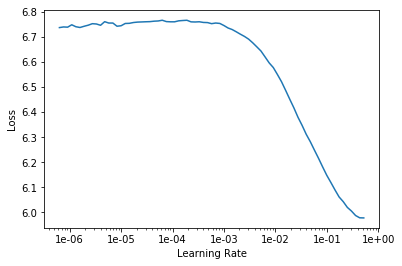

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-3,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.807031,4.220005,0.228810,00:11


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


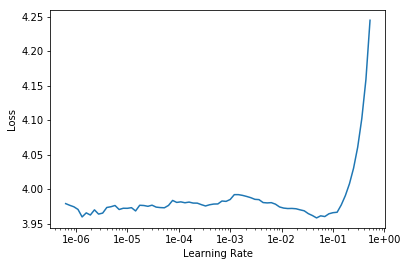

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


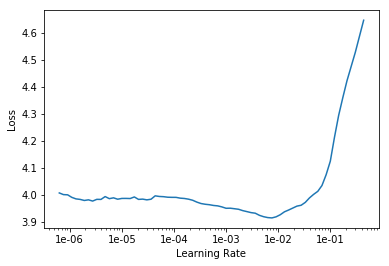

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(20, max_lr=slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.922860,4.147615,0.238730,00:14
1,3.837424,4.050717,0.252937,00:14
2,3.705735,3.955993,0.263730,00:14
3,3.534637,3.896224,0.269603,00:14
4,3.316201,3.887389,0.276905,00:14
5,3.050363,3.924319,0.281190,00:14
6,2.728230,4.018298,0.289683,00:14
7,2.406138,4.129215,0.292222,00:14
8,2.092464,4.225383,0.295238,00:14
9,1.909027,4.348126,0.292857,00:14


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "please check"
N_WORDS = 5
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

please check your dm xxbos pls check
please check your dm xxbos its been


In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
split = math.floor((len(df_1) - len(df_1)*0.1))
train_df = df_1[:split].reset_index()
valid_df = df_1[split:].reset_index()

In [ ]:
df_1.head()

,tweet,label
0,because they answered you doesnt mean they are...,pos
1,because they answered you doesnt mean they are...,pos
2,there you have it,pos
3,ok i understand and i also have some questions...,pos
4,i have not been able to use my first bank appl...,neg


In [ ]:
# mm = {
#     1:"neg",
#     0:"pos"
# }
# valid_df["label"] = valid_df["sentiment"].map(mm)
# train_df["label"] = train_df["sentiment"].map(mm)

In [ ]:
valid_df.drop(["index","sentiment"],axis=1,inplace=True)
train_df.drop(["index","sentiment"],axis=1,inplace=True)

In [ ]:
valid_df.head()

,tweet,label
0,our workshop didnt have as many attendees as ...,pos
1,is there a way to disconnect a bank account fr...,neg
2,hello fidelitycares thank you for contacting...,pos
3,and i was promised a reversal on the 6th of ma...,neg
4,hi we sent you a dm,pos


In [ ]:
data_clas = (TextList.from_df(df_1,vocab=data_m.vocab,path=path)
             .random_split_by_pct(0.1)
             .label_from_df(cols="label")
             .databunch(bs=bs)
            )

In [ ]:
data_clas.save('data_clas.pkl')


In [ ]:
data_clas.path

PosixPath('drive/My Drive/bank-sentiment')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

text,target
xxbos please note that i do nt need the session i d but the receipt i can print out so i can xxunk to the school as proof of evidence,pos
xxbos xxunk u for it kind advice i hv try all d avenue 2 lodge my complain b xxunk a unable 2 resolve d issue over a xxunk now,neg
xxbos your branch at station road phc stole xxunk from my account i do nt care how you are going to do it but i want my money back,neg
xxbos your acct xxunk xxrep 4 x xxunk has been debited with xxunk xxrep 4 0 on xxunk 05 24 50 by qs894 1013 xxrep 4 0 xxunk,neg
xxbos l xxrep 5 o l a whole day after plus it was nt posted till i had to call and xxunk almost made me miss out on,neg


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6741 items)
x: TextList
xxbos because they answered you does nt mean they are prompt when answering others stop the hype and,xxbos because they answered you does nt mean they are prompt when answering others stop the hype and,xxbos there you have it,xxbos ok i understand and i also have some questions to ask about an account my xxunk opened for me and my xxunk,xxbos i have not been able to use my first bank application the response i got is network error which is not
y: CategoryList
pos,pos,pos,pos,neg
Path: drive/My Drive/bank-sentiment;

Valid: LabelList (749 items)
x: TextList
xxbos use d dm they reply asap,xxbos its over xxunk now,xxbos i have call your customer more than 3 times and no response wasting my 1000 naira airtime do needful an,xxbos can you people please check your dm,xxbos do you xxunk the kind of people you want to attend to
y: CategoryList
pos,neg,neg,pos,pos
Path: drive/My Drive/bank-sentiment;

Test: None, model

In [ ]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [30, 400]            0          False     
______________________________________________________________________
RNNDropout           [30, 1152]           0          False     
______________________________________________________________________
RNNDropout           [30, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


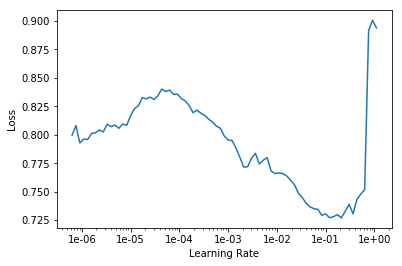

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.600929,0.397881,0.821095,00:08
1,0.585671,0.497418,0.753004,00:08
2,0.588969,0.421233,0.813084,00:07


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(4e-2/(2.6**4),4e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.537554,0.482746,0.798398,00:10
1,0.457930,0.362965,0.847797,00:10


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


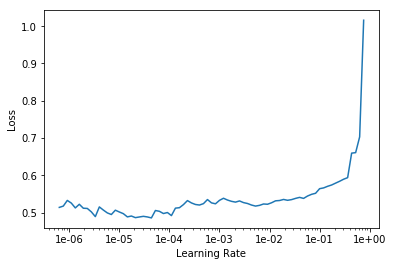

In [ ]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.428685,0.355607,0.839786,00:15
1,0.370394,0.362681,0.855808,00:15


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.345396,0.383603,0.854473,00:19


In [ ]:
learn.save("final")

In [ ]:
learn.predict(df_1.iloc[5,0])

(Category neg, tensor(0), tensor([0.9522, 0.0478]))

In [ ]:
valid_df.iloc[5,1]

'neg'

In [ ]:
valid_df.iloc[0,0]

'our  workshop didnt have as many attendees as the last year we did it but these ones are from the  of'

In [ ]:
learn.save("final")

In [ ]:
mm = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [ ]:
mm.load("final")

In [ ]:
mm.predict(valid_df.iloc[5,0])

(Category pos, tensor(1), tensor([0.2016, 0.7984]))

InFerence method

In [ ]:
path="drive/My Drive/bank-sentiment/"

In [ ]:
bs=30

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

text,target
xxbos i tried to transfer some cash to a gtb account via the ussd code gtb did nt show up as an option of banks to make the transfer to,neg
xxbos you asked to send my account number and i did and no one has gotten back to me in two days is this how you treat a customer,neg
xxbos so in total 3 times failed recharge of 1000 that did nt work but i was debited 1 remaining on the 18 and 2 on the 19,neg
xxbos i made a transaction via pos amp it was declined but i was debited i filled the complaint form about 3 weeks ago amp no response yet,neg
xxbos do you know you can apply to be one of the 40 lucky women to get loans up to n5 xxrep 6 0 at zero interest visit,pos


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6741 items)
x: TextList
xxbos because they answered you does nt mean they are prompt when answering others stop the hype and,xxbos because they answered you does nt mean they are prompt when answering others stop the hype and,xxbos there you have it,xxbos ok i understand and i also have some questions to ask about an account my xxunk opened for me and my xxunk,xxbos i have not been able to use my first bank application the response i got is network error which is not
y: CategoryList
pos,pos,pos,pos,neg
Path: drive/My Drive/bank-sentiment;

Valid: LabelList (749 items)
x: TextList
xxbos use d dm they reply asap,xxbos its over xxunk now,xxbos i have call your customer more than 3 times and no response wasting my 1000 naira airtime do needful an,xxbos can you people please check your dm,xxbos do you xxunk the kind of people you want to attend to
y: CategoryList
pos,neg,neg,pos,pos
Path: drive/My Drive/bank-sentiment;

Test: None, model

In [ ]:
learn.load("final")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6741 items)
x: TextList
xxbos because they answered you does nt mean they are prompt when answering others stop the hype and,xxbos because they answered you does nt mean they are prompt when answering others stop the hype and,xxbos there you have it,xxbos ok i understand and i also have some questions to ask about an account my xxunk opened for me and my xxunk,xxbos i have not been able to use my first bank application the response i got is network error which is not
y: CategoryList
pos,pos,pos,pos,neg
Path: drive/My Drive/bank-sentiment;

Valid: LabelList (749 items)
x: TextList
xxbos use d dm they reply asap,xxbos its over xxunk now,xxbos i have call your customer more than 3 times and no response wasting my 1000 naira airtime do needful an,xxbos can you people please check your dm,xxbos do you xxunk the kind of people you want to attend to
y: CategoryList
pos,neg,neg,pos,pos
Path: drive/My Drive/bank-sentiment;

Test: None, model

In [ ]:
learn.predict('ok, thank you')

(Category pos, tensor(1), tensor([0.0486, 0.9514]))

In [ ]:
learn.